learning start
#Plot the loss curve



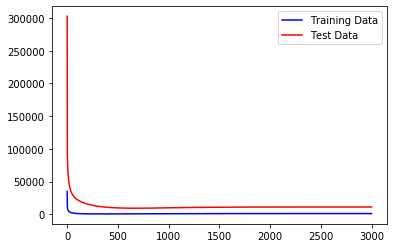

------------------------------------------

#Plot the accuracy curve



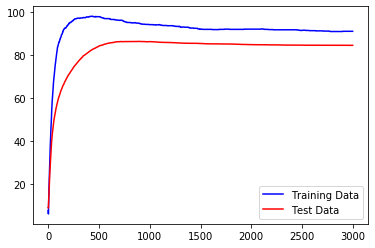

------------------------------------------

#Plot the accuracy value

Traing data accuracy : 91.0
Test data accuracy   : 84.47777777777777
------------------------------------------


In [37]:
import matplotlib.pyplot as plt
import numpy as np


print("learning start")

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1

_X_train = list_image.T[:1000]
_l_train = list_label.T[:1000]
_X_test = list_image.T[1000:]
_l_test = list_label.T[1000:]


### Definition of Class and Functions
class NeuralNetwork(object):
    def __init__(self,alpha,iteration,l2):
        self.alpha = alpha
        self.iteration = iteration
        self.l2=l2
    
    def _onehot(self,label,n_classes):
        onehot = np.zeros((n_classes,label.shape[0]))
        for i, val in enumerate(label.astype(int)):
            onehot[val,i] = 1
        return onehot.T #10,000 rows, 10 cols
    
    def _sigmoid(self,z):
        return 1/(1+np.exp(-z))
    
    def _activate(self,z):
        return self._sigmoid(z)
    
    def _jumpLayer(self,X,u,b):
        y = np.dot(X,u) + b
        return self._activate(y)
    
    def _forward(self,X): #정방향 계산
        y1_a = self._jumpLayer(X,self.u1,self.ub1) #y1의 활성화
        y2_a = self._jumpLayer(y1_a,self.u2,self.ub2) #y2의 활성화
        #y3_a = self._jumpLayer(y2_a,self.u3,self.ub3)
        h_a = self._jumpLayer(y2_a,self.w,self.wb) #h의 활성화
        return y1_a,y2_a,h_a
    
    
    def _cost(self,label,output):
        term1 = (-label*np.log(output))
        term2 = (1-label)*np.log(1.-output)
        cost = np.sum(term1 - term2)
        return cost
    
    def _predict(self,h_a):
        prdt = []
        for arg in h_a:
            prdt.append(np.argmax(arg))
        return prdt
    
    def _accuracy(self,l_label,predict):
        acr = 0
        for x,y in zip(l_label,predict):
            if(x == y):
                acr += 1
        return acr*100/len(l_label)
    
    def _classify(self,r_label,e_label,c):
        ret = [[] for _ in range(10)]
        if(c):#Classified correctly
            for i in range(len(r_label)):
                if((r_label[i] == e_label[i]) and (len(ret[r_label[i]]) <= 10)):
                    ret[r_label[i]].append(i)
        else:#Classified incorrectly
            for i in range(len(r_label)):
                if((r_label[i] != e_label[i]) and (len(ret[r_label[i]]) <= 10)):
                    ret[r_label[i]].append(i)
        return ret
            
    
    def fit(self,X_train,l_train,X_test,l_test):        
        
        self.cost_train = []
        self.accuracy_train = []
        self.cost_test = []
        self.accuracy_test = []        
        
        #theta 값 생성
        self.u1 = np.random.normal(0,1,size=(784,256))
        self.ub1 = np.zeros(256)
        self.u2 = np.random.normal(0,1,size=(256,256))
        self.ub2 = np.zeros(256)
        #self.u3 = np.random.normal(0,1,size=(256,10))
        #self.ub3 = np.zeros(10)
        self.w = np.random.normal(0,1,size=(256,10))
        self.wb = np.zeros(10)
        l_onehot = self._onehot(l_train,10)
        l_onehott = self._onehot(l_test,10)
        
        for i in range(self.iteration):
            ##forward
            y1_a, y2_a, h_a = self._forward(X_train)
            y1_aa,y2_aa,h_aa = self._forward(X_test)
            ##back-propagation
            J_h = h_a - l_onehot #(h^ - l)
            #y3_y3 = y3_a*(1-y3_a) #sigmoid(y)*(1-sigmoid(y))
            #J_y3 = np.dot(J_h,self.w.T)*y3_y3
            y2_y2 = y2_a*(1-y2_a) #sigmoid(z)*(1-sigmoid(z))
            J_y2 = np.dot(J_h,self.w.T)*y2_y2
            y1_y1 = y1_a*(1-y1_a) #sigmoid(y)*(1-sigmoid(y))
            J_y1 = np.dot(J_y2,self.u2.T)*y1_y1
            
            grad_u1 =np.dot(X_train.T,J_y1)
            grad_ub1 = np.sum(J_y1)
            
            grad_u2 = np.dot(y1_a.T,J_y2)
            grad_ub2 = np.sum(J_y2)
            
            #grad_u3 = np.dot(y2_a.T,J_y3)
            #grad_ub3 = np.sum(J_y3)
            
            grad_w = np.dot(y2_a.T,J_h)
            grad_wb = np.sum(J_h)
            
            delta_u1 = (grad_u1 + self.l2 * self.u1)
            delta_ub1 = grad_ub1
            self.u1 -= self.alpha * delta_u1
            self.ub1 -= self.alpha * delta_ub1
            
            delta_u2 = (grad_u2 + self.l2 * self.u2)
            delta_ub2 = grad_ub2
            self.u2 -= self.alpha * delta_u2
            self.ub2 -= self.alpha * delta_ub2
            
            #delta_u3 = (grad_u3 + self.l2 * self.u3)
            #delta_ub3 = grad_ub3
            #self.u3 -= self.alpha * delta_u3
            #self.ub3 -= self.alpha * delta_ub3
            
            delta_w = (grad_w + self.l2 * self.w)
            delta_wb = grad_wb
            self.w -= self.alpha * delta_w
            self.wb -= self.alpha * delta_wb
            
            self.predict_train = self._predict(h_a)
            self.predict_test = self._predict(h_aa)
            self.cost_train.append(self._cost(l_onehot,h_a))
            self.cost_test.append(self._cost(l_onehott,h_aa))
            train_acc = self._accuracy(l_train,self.predict_train)
            self.accuracy_train.append(train_acc)
            train_acc = self._accuracy(l_test,self.predict_test)
            self.accuracy_test.append(train_acc)
        
        self.classified_image_c = self._classify(l_test,self.predict_test,True)
        self.classified_image_w = self._classify(l_test,self.predict_test,False)
        
        return self
    
nn = NeuralNetwork(0.0002,3000,10)
nn.fit(X_train = _X_train,
      l_train = _l_train,
      X_test = _X_test,
      l_test = _l_test)

### Plot the requirements
#Plot the loss curve
print("#Plot the loss curve")
print("")
plt.plot(nn.cost_train,color="blue",label="Training Data")
plt.plot(nn.cost_test,color="red",label="Test Data")
plt.legend()
plt.show()

print("------------------------------------------")
print("")
#Plot the accuracy curve
print("#Plot the accuracy curve")
print("")
plt.plot(nn.accuracy_train,color="blue",label="Training Data")
plt.plot(nn.accuracy_test,color="red",label="Test Data")
plt.legend()
plt.show()

print("------------------------------------------")
print("")
#Plot the accuracy value
print("#Plot the accuracy value")
print("")
print("Traing data accuracy : {0}".format(nn.accuracy_train[nn.iteration-1]))
print("Test data accuracy   : {0}".format(nn.accuracy_test[nn.iteration-1]))

print("------------------------------------------")